### Import libraries

In [13]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import platform

import random
random.seed(seed)

In [14]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [15]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from PIL import Image
from sklearn.model_selection import KFold
import zipfile

In [16]:
# Setup Mixed Precision

# Detect TPY
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None

if tpu:
  policyConfig = 'mixed_bfloat16'
else:
  policyConfig = 'mixed_float16'

policy = tf.keras.mixed_precision.Policy(policyConfig)
# tf.keras.mixed_precision.set_global_policy(policy)

### Load and process the (augmented) dataset

In [17]:
file_path = 'augmented_data.npz'
loaded_data = np.load(file_path, allow_pickle = True)

# Access the 'data' and 'labels' arrays
X = loaded_data['data']
labels = loaded_data['labels']

print(len(X))
print(len(labels))

X = X.astype('float32') / 255

healthy = []
unhealthy = []

# Iterate through the images to separate them into the proper set
for i, image in enumerate(X):
    if labels[i] == 'unhealthy':
        unhealthy.append(image)
    else:
        healthy.append(image)

np.random.shuffle(healthy)
np.random.shuffle(unhealthy)
# ChatGPT suggests to shuffle images to avoid batches containing the same images

print(len(healthy))
print(len(unhealthy))

13450
13450
6660
6790


In [18]:
# Codifica delle etichette 'healthy' e 'unhealthy' in numeri
label_dict = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_dict[label] for label in labels]) # 0 è [1,0]

# Convert labels to one-hot encoding format
y = tfk.utils.to_categorical(y,2)

# Split data into train_val and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=seed, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=seed, test_size=0.3, stratify=y_temp)


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Print shapes of the datasets
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (9415, 96, 96, 3), y_train shape: (9415, 2)
X_val shape: (2824, 96, 96, 3), y_val shape: (2824, 2)


In [19]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 100

img_height = 96
img_width = 96

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (96, 96, 3), Output Shape: (2,), Batch Size: 32, Epochs: 100


### Setup the model

In [20]:
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='auto'),
]

In [21]:
# Macs with Apple Silicon suffer performance penalties when using the modern Adam optimizer
# Detect system specs and select the appropriate optimizer

if platform.system() == "Darwin" and platform.processor() == "arm":
    optimizer = tf.keras.optimizers.legacy.Adam()
else:
    optimizer = tf.keras.optimizers.Adam()

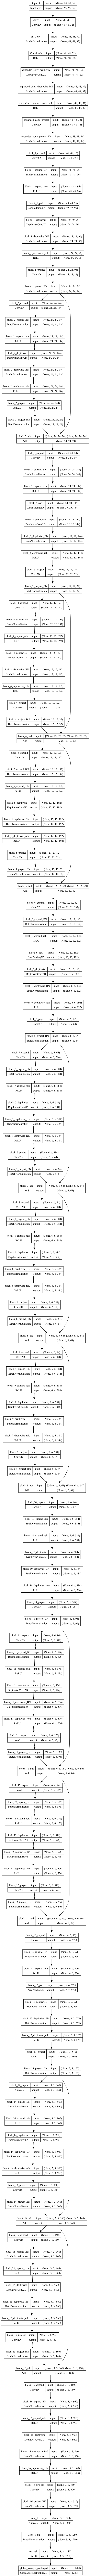

In [22]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

In [23]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='sigmoid')(x)  # Modifica del numero di neuroni

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


### Train the model

In [24]:
tl_history = tl_model.fit(
    x=preprocess_input(X_train * 255), #what does it do
    y=y_train,
    batch_size=128,
    epochs=2000,
    validation_data=(preprocess_input(X_val * 255), y_val),
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=200, restore_best_weights=True)]
).history

Epoch 1/2000
74/74 [==============================] - 9s 85ms/step - loss: 0.5741 - accuracy: 0.7127 - val_loss: 0.4926 - val_accuracy: 0.7723
Epoch 2/2000
74/74 [==============================] - 4s 54ms/step - loss: 0.4668 - accuracy: 0.7842 - val_loss: 0.4530 - val_accuracy: 0.7967
Epoch 3/2000
74/74 [==============================] - 4s 50ms/step - loss: 0.4342 - accuracy: 0.7998 - val_loss: 0.4437 - val_accuracy: 0.7939
Epoch 4/2000
74/74 [==============================] - 4s 51ms/step - loss: 0.4148 - accuracy: 0.8144 - val_loss: 0.4235 - val_accuracy: 0.8056
Epoch 5/2000
74/74 [==============================] - 4s 51ms/step - loss: 0.3978 - accuracy: 0.8246 - val_loss: 0.4143 - val_accuracy: 0.8123
Epoch 6/2000
74/74 [==============================] - 4s 51ms/step - loss: 0.3870 - accuracy: 0.8339 - val_loss: 0.4087 - val_accuracy: 0.8169
Epoch 7/2000
74/74 [==============================] - 4s 51ms/step - loss: 0.3766 - accuracy: 0.8367 - val_loss: 0.4063 - val_accuracy: 0.8180

In [25]:
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"model_{formatted_datetime}_trained.zip"
tl_model.save(zipfile_name)

### Fine-Tuning

In [28]:
#Re-load the model after transfer learning
ft_model = tfk.models.load_model(zipfile_name)
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [30]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tru

In [32]:
# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [33]:
# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=optimizer, metrics='accuracy')

In [34]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
589/589 [==============================] - 23s 34ms/step - loss: 0.7106 - accuracy: 0.7611 - val_loss: 2.0215 - val_accuracy: 0.5737
Epoch 2/200
589/589 [==============================] - 18s 30ms/step - loss: 0.3514 - accuracy: 0.8424 - val_loss: 0.7831 - val_accuracy: 0.8006
Epoch 3/200
589/589 [==============================] - 18s 31ms/step - loss: 0.2687 - accuracy: 0.8874 - val_loss: 0.6839 - val_accuracy: 0.8233
Epoch 4/200
589/589 [==============================] - 18s 31ms/step - loss: 0.2145 - accuracy: 0.9127 - val_loss: 0.6565 - val_accuracy: 0.8378
Epoch 5/200
589/589 [==============================] - 19s 32ms/step - loss: 0.1843 - accuracy: 0.9267 - val_loss: 0.5038 - val_accuracy: 0.8474
Epoch 6/200
589/589 [==============================] - 19s 32ms/step - loss: 0.1430 - accuracy: 0.9436 - val_loss: 0.6597 - val_accuracy: 0.8375
Epoch 7/200
589/589 [==============================] - 19s 32ms/step - loss: 0.1327 - accuracy: 0.9466 - val_loss: 1.4088 - val_ac

In [35]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8968


In [36]:
# Save the best model
ft_model.save('FineTuningModel')

### Save the model

In [38]:
flip = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
])

rotation = tf.keras.Sequential([
  tfkl.RandomRotation(0.2),
])

zoom = tf.keras.Sequential([
  tfkl.RandomZoom(0.2),
])

translation = tf.keras.Sequential([
  tfkl.RandomTranslation(0.2,0.2),
])

contrast = tf.keras.Sequential([
  tfkl.RandomContrast(0.75),
])

def apply_random_brightness(image):
    # Convert to TensorFlow tensor
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

    # Apply random brightness
    brightness_factor = tf.random.uniform([], -0.5, 0.5)  # Adjust the range as needed
    brightened_image = tf.image.adjust_brightness(image_tensor, brightness_factor)

    # Convert back to NumPy array
    brightened_image_np = brightened_image.numpy()

    return brightened_image_np

In [41]:
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"model_{formatted_datetime}_finetuned.zip"
tl_model.save(zipfile_name)

X_test_1 = X_val
X_test_2 = rotation(X_val)
X_test_3 = flip(X_val)

true_labels = y_val

# Make predictions on each test set
predictions_1 = ft_model.predict(X_test_1)
predictions_2 = ft_model.predict(X_test_2)
predictions_3 = ft_model.predict(X_test_3)

# Assuming binary classification, adjust if needed

best_accuracy_1 = 0.0
limit_1 = 0.0

for limit in range(100):
    predicted_labels_1 = (predictions_1 > (limit / 100.0)).astype(int)
    accuracy_1 = np.sum(predicted_labels_1 == true_labels) / len(true_labels)

    if (accuracy_1 < best_accuracy_1):
        continue

    best_accuracy_1 = accuracy_1
    limit_1 = (limit / 100.0)

best_accuracy_2 = 0.0
limit_2 = 0.0

for limit in range(100):
    predicted_labels_2 = (predictions_2 > (limit / 100.0)).astype(int)
    accuracy_2 = np.sum(predicted_labels_2 == true_labels) / len(true_labels)

    if (accuracy_2 < best_accuracy_2):
        continue

    best_accuracy_2 = accuracy_2
    limit_2 = (limit / 100.0)

best_accuracy_3 = 0.0
limit_3 = 0.0

for limit in range(100):
    predicted_labels_3 = (predictions_3 > (limit / 100.0)).astype(int)
    accuracy_3 = np.sum(predicted_labels_3 == true_labels) / len(true_labels)

    if (accuracy_3 < best_accuracy_3):
        continue

    best_accuracy_3 = accuracy_3
    limit_3 = (limit / 100.0)


print("Limit on Test Set 1:", limit_1)
print("Limit on Test Set 2:", limit_2)
print("Limit on Test Set 3:", limit_3)

predicted_labels_1 = (predictions_1 > limit_1).astype(int)
predicted_labels_2 = (predictions_2 > limit_2).astype(int)
predicted_labels_3 = (predictions_3 > limit_3).astype(int)

# Compare the results
accuracy_1 = np.sum(predicted_labels_1 == true_labels) / len(true_labels)
accuracy_2 = np.sum(predicted_labels_2 == true_labels) / len(true_labels)
accuracy_3 = np.sum(predicted_labels_3 == true_labels) / len(true_labels)

print("Accuracy on Test Set 1:", accuracy_1)
print("Accuracy on Test Set 2:", accuracy_2)
print("Accuracy on Test Set 3:", accuracy_3)


final_prediction = []

for i in range(len(predictions_1)):
    healthy_prediction = predicted_labels_1[i] + predicted_labels_2[i] + predicted_labels_3[i]

    if np.sum(healthy_prediction) >= 2:
        final_prediction.append([1])

    else:
        final_prediction.append([0])

final_accuracy = np.sum(final_prediction == true_labels) / len(true_labels)

print("Accuracy of Final Prediction:", final_accuracy)

89/89 [==============================] - 2s 18ms/step
Limit on Test Set 1: 0.51
Limit on Test Set 2: 0.41
Limit on Test Set 3: 0.58
Accuracy on Test Set 1: 1.4309490084985836
Accuracy on Test Set 2: 1.3792492917847026
Accuracy on Test Set 3: 1.3834985835694051
Accuracy of Final Prediction: 1.0


Predictions on Test Set 1:
[[1.39170551e-08 1.00000000e+00]
 [1.84316718e-06 9.99998093e-01]
 [4.31197700e-09 1.00000000e+00]
 [9.99671698e-01 3.25934496e-04]
 [3.63341286e-07 9.99999642e-01]
 [9.99992967e-01 5.39802159e-06]
 [9.74127352e-01 2.68469546e-02]
 [8.94497097e-01 1.10052831e-01]
 [8.14415812e-02 9.21747863e-01]
 [1.07109495e-01 8.90585780e-01]]

Predictions on Test Set 2:
[[2.6985842e-07 9.9999976e-01]
 [2.4113693e-05 9.9997509e-01]
 [1.4613576e-01 8.6032593e-01]
 [8.7776119e-01 1.2508221e-01]
 [7.7219568e-03 9.9308962e-01]
 [9.9946934e-01 4.6191330e-04]
 [9.7420645e-01 2.5039647e-02]
 [9.4130814e-01 5.9205189e-02]
 [2.5842644e-04 9.9974912e-01]
 [1.7916544e-04 9.9981099e-01]]

Predictions on Test Set 3:
[[1.39170551e-08 1.00000000e+00]
 [7.42780268e-02 9.28010881e-01]
 [4.31197700e-09 1.00000000e+00]
 [9.99671698e-01 3.25934496e-04]
 [3.63341286e-07 9.99999642e-01]
 [9.99995351e-01 4.13157886e-06]
 [5.77815175e-01 4.34755862e-01]
 [1.21264435e-01 8.83001328e-01]
 [7.6060474

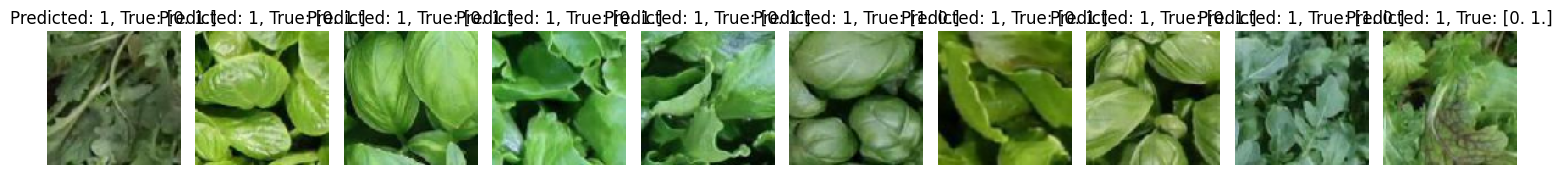

In [42]:
# N predictions to display
N = 10

# Output the first N predictions for each set
print("Predictions on Test Set 1:")
print(predictions_1[:N])

print("\nPredictions on Test Set 2:")
print(predictions_2[:N])

print("\nPredictions on Test Set 3:")
print(predictions_3[:N])

print("\nFinal Predictions:")
print(np.array(final_prediction[:N]))

# Create subplots
fig, axes = plt.subplots(1, N, figsize=(15, 5))

for i in range(N):
    # Plot the original image from X_val
    ax = axes[i]

    # Ensure the image is properly scaled and displayed
    ax.imshow((X_val[i] * 255).astype(np.uint8))

    # Set the title with the predicted and true labels
    ax.set_title(f"Predicted: {final_prediction[i][0]}, True: {true_labels[i]}")

    ax.axis('off')

plt.tight_layout()
plt.show()


### Plot the training

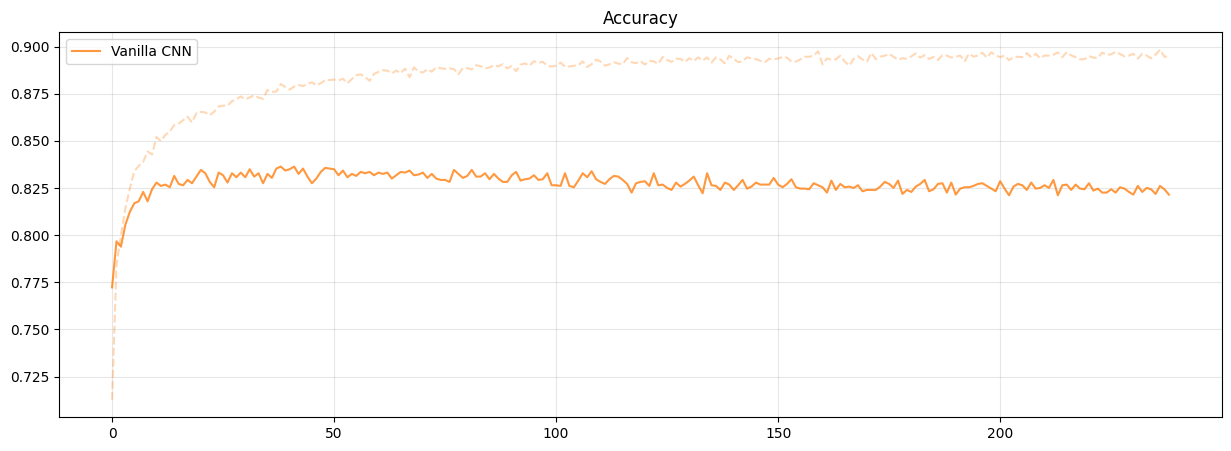

In [43]:
# Plot the training
plt.figure(figsize=(15, 5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Save the model and create submission

In [44]:
import os
import zipfile
from datetime import datetime
import tensorflow as tf
from os.path import basename

# Specify the name of the submission folder
submission_folder = "SubmissionModel"

# Save best epoch model
tl_model.save(os.path.join(submission_folder, "SubmissionModel"))

# Save the model.py file in the main directory
with open("model.py", "w") as model_file:
    model_file.write("""

import os
import tensorflow as tf
from tensorflow.keras import layers as tfkl

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X):
        # Define the RandomRotation layer
        rotation = tf.keras.Sequential([
            tfkl.RandomRotation(0.3),
        ])

        # Define the RandomFlip layer
        flip = tf.keras.Sequential([
            tfkl.RandomFlip("vertical"),
        ])

        limit = tf.constant(0.56, dtype=tf.float32)
                     
        X = X.astype('float32') / 255

        X_test_1 = X
        X_test_2 = rotation(X)
        X_test_3 = flip(X)

        out1 = self.model.predict(X_test_1)
        out2 = self.model.predict(X_test_2)
        out3 = self.model.predict(X_test_3)

        out1 = tf.argmax(out1, axis=-1)  # Shape [BS]
        out2 = tf.argmax(out2, axis=-1)  # Shape [BS]
        out3 = tf.argmax(out3, axis=-1)  # Shape [BS]

        out = []  # Initialize out as an empty list

        for i in range(len(out1)):
            hp = 0

            if tf.cast(out1[i], tf.float32) > limit:
                hp += 1

            if tf.cast(out2[i], tf.float32) > limit:
                hp += 1

            if tf.cast(out3[i], tf.float32) > limit:
                hp += 1

            if hp >= 2:
                out.append([1])
            else:
                out.append([0])

        out = tf.argmax(out, axis=-1)  # Shape [BS]

        return out
""")

# Create an empty metadata file in the main directory
open("metadata", "w").close()

# Get the current date and time
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"{submission_folder}_{formatted_datetime}.zip"

with zipfile.ZipFile(zipfile_name, 'w') as zip_file:
    # Add the entire "SubmissionModel" folder and its contents to the archive
    for foldername, subfolders, filenames in os.walk(submission_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, submission_folder)

            if (foldername in ["SubmissionModel", "SubmissionModel/model", "SubmissionModel/model/variables", "SubmissionModel/variables"]):
                continue

            # print(foldername)
            print(file_path)

            zip_file.write(file_path, arcname)

    # Add other files to the archive (model.py and metadata)
    zip_file.write("model.py", arcname="model.py")
    zip_file.write("metadata", arcname="metadata")

print(zipfile_name)


SubmissionModel/SubmissionModel/fingerprint.pb
SubmissionModel/SubmissionModel/keras_metadata.pb
SubmissionModel/SubmissionModel/saved_model.pb
SubmissionModel/SubmissionModel/variables/variables.data-00000-of-00001
SubmissionModel/SubmissionModel/variables/variables.index
SubmissionModel_20231115_202134.zip
